<a href="https://colab.research.google.com/github/carlos-edhr/hands-on-ml/blob/main/02_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Classification

 This notebook is about machine learning classification using the MNIST dataset, which is a set of 70,000 images of handwritten digits. Each image is labeled with the digit it represents.

In [12]:
# Environment setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

In [13]:
# Scikit-Learn provided function to downlaod MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [14]:
# Data-Target arrays are included in datasets loaded by Scikit-learn
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [15]:
y.shape

(70000,)

Saving figure some_digit_plot


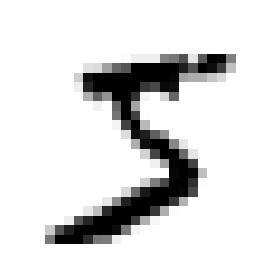

In [16]:
# Show digit from dataset
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [17]:
# Previous digit label
y[0]

'5'

In [18]:
y = y.astype(np.uint8)

In [19]:
# Creating a test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

We will start the solution by identifying just one digit.

In [21]:
y_train_5 = (y_train == 5) # True for all numbers: 5
y_test_5 = (y_test == 5)

Next we proceed to choose a classifier and train it.

In [22]:
# Estimator: SGDClassifier - Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Our model can now detect images of the number 5

In [25]:
# the some_digit variable was previously set to 5
sgd_clf.predict([some_digit])

array([ True])

It seems that at this stage our model performs correctly, now we proceed to evaluate it's performance.

## Performance Measures

### Measuring accuracy using cross-validation

**Implementing cross-validation**

For greater control over cross-validation we can create our own function:

In [27]:
# Custom implementation of Scikit-Learn's cross_val_score()
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred)) 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


Now we evaluate the SGDClassifier model with cross_val_score().

In [29]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

The ratio of correct predictions is high - 96% - however let's take a look at a classifier of "not-5" images: 

In [32]:
# Detect if element is not 5
from sklearn.base import BaseEstimator 

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)


In [33]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Accuracy is high because only 10% of the images are 5s.

This shows that accuracy is generally not the preferred performance measure for classifiers.

### Confusion Matrix

A confusion matrix is a better way to evaluate the performance of a classifier. We start by using `cross_val_predict()` to count the number of times instances of class A are classified as class B.

In [34]:
# cross_val_predict() performs K-fold cross-validation but it returns the predictions made on each test fold
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now we get the confusion matrix

In [36]:
# Scikit-learn has a confusion_matrix function. Rows represent an actual class, columns represent a predicted class
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

We observe the following: 
* First row - negative class:
  * 53,892 were classified correctly as non-5s - false positives 
  * 1,522 were wrongly classified as 5s  - False positives
* Second row - postive class:
  * 1,325 wrongly classified as non-5s - false negatives
  * 4,096 correctly classified as 5s - true positives

'A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right)'

In [37]:
# Perfect classifier example
y_train_perfect_predictions = y_train_5 
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

A more concise metric is the accuracy of the positive predictions, known as the *precision* of the classifier

precision $= \frac{TP}{TP + FP}$

$TP$ is the number of true positives, and $FP$ is the number of false positives.

Precision is usually used with the metric called *recall*, or *sensitivity* or the *true positive rate*(TPR). This is the ratio of positive instances that are correctly detected by the classifier

recall $= \frac{TP}{TP + FN}$

$FN$ is the number of false negatives

### Precision and Recall

Now we will use Sci-kit learn's implementation of precision and recall

In [42]:
from sklearn.metrics import precision_score, recall_score 
# Precision, Recall
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

The $F_1$ score is the *harmonic mean* of precision and recall. The harmonic mean gives much more weight to low values.

$F_1 = \frac{2}{\frac{1}{\text{precision} + \frac{1}{recall} } } = 2 \times \frac{\text{precision} \times \text{recall} }{ \text{precision} + \text{recall} } = \frac{TP}{TP + \frac{FN + FP}{2}}$

In [43]:
# sklearn f1 implementation is the f1_score() function
from sklearn.metrics import f1_score 
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade-Off

Increasing precision reduces recall, and
vice versa. This is called the precision/recall trade-off.

In [46]:
# We call the classifier's decision_function() method, which returns a score for each instance
y_scores =sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [47]:
# This is the default threshold for the SGDClassifier
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [48]:
# Now we proceed to raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred 

array([False])

"This confirms that raising the threshold decreases recall. The image actually repre‐
sents a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 8,000."

To decide which threshold to use, we now call the `cross_val_predict()` fucntion to get the scores of all the instances in the training set and instead of predictions we specify to get *decision scores*.

In [50]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

With `y_scores` now compute precision and recall for all possible thresholds using `precision_recall_curve()`

In [51]:
from sklearn.metrics import precision_recall_curve 

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

We now plot the precision and recall as functions of the threshold valueusing Matplotlib

Saving figure precision_recall_vs_threshold_plot


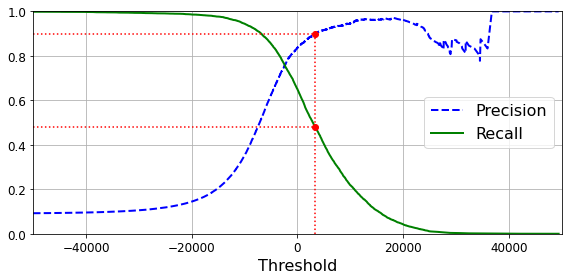

In [52]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()
